In [1]:
import numpy as np
np.random.seed(42)

In [2]:
d_img = 9000 # number of images
m = 460 # number of local configurations sampled in a single image
k = 12 # number of distinct local configurations (histogram bins)
hist = np.array([1/k]*k)
hist

array([0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.08333333,
       0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.08333333,
       0.08333333, 0.08333333])

In [3]:
def corr_cov(data_matrix, output='corr'):
    """
    Calculates correlation matrix for n_exp multinomial experiments with n samples each
    resulting in k possible states.

    Parameters
    ----------
    data_matrix: ndarray((n_exp, k), dtype=float)
                 data matrix of n_exp experiments with results in k histogram bins (states)
    output: str
            defines whether correlation ('corr' - default) or covariance ('cov') matrix is returned

    Returns
    -------
    corr_mat: ndarray((k, k), dtype=float)
            correlation matrix 
                 
    """
    
    n_exp = data_matrix.shape[0]

    # calculate averages of the columns
    averages = np.stack([np.mean(data_matrix, axis=0)]*n_exp, axis=0)
    
    # data deviations from averages
    data_centered = data_matrix - averages
    
    # calculate covariance matrix
    cov_mat = data_centered.T.dot(data_centered)/(n_exp - 1.)
    
    if output == 'cov':
        return cov_mat

    # inverse square root variance diagonal matrix
    var_srinv = np.sqrt(np.diag(1.0/np.diag(cov_mat)))

    # correlation matrix
    corr_mat = var_srinv.dot(cov_mat).dot(var_srinv)
    
    return corr_mat

In [4]:
def n_effective(data_matrix):
    """
    Calculate the effective number of samples from a data matrix of a multinomial distribution.
    Calls corr_cov function to calculate covariance matrix
    
    Parameters
    ----------
    data_matrix: ndarray((n_exp, k), dtype=float)
                 data matrix of n_exp experiments with results in k histogram bins (states)

    Returns
    -------
    n_eff: float
           effective number of samples
    """
    
    v = np.diag(corr_cov(data_matrix, output='cov'))
    p = np.mean(data_matrix, axis=0)
    
    # vector of effective sample numbers for each histogram bin
    n_eff_vec = p*(1-p)/v
    
    # mean value (should it be minimum value?)
    n_eff = np.mean(n_eff_vec)
    #n_eff = np.min(n_eff_vec)
    
    return n_eff

In [5]:
mat = np.random.multinomial(m, hist, (d_img,))/m

hist2 = np.copy(hist)
hist2[0:k//2] = hist2[0:k//2]+0.01
hist2[k//2:] = hist2[k//2:]-0.01
print(hist2)
mat2 = np.random.multinomial(m, hist2, (d_img//2,))/m

hist3 = np.copy(hist)
hist3[0:k//2] = hist3[0:k//2]-0.01
hist3[k//2:] = hist3[k//2:]+0.01
print(hist3)
mat3 = np.random.multinomial(m, hist3, (d_img//2,))/m

[0.09333333 0.09333333 0.09333333 0.09333333 0.09333333 0.09333333
 0.07333333 0.07333333 0.07333333 0.07333333 0.07333333 0.07333333]
[0.07333333 0.07333333 0.07333333 0.07333333 0.07333333 0.07333333
 0.09333333 0.09333333 0.09333333 0.09333333 0.09333333 0.09333333]


In [6]:
ave = np.stack([np.mean(mat, axis=0)]*d_img, axis=0)
ave2 = np.stack([np.mean(mat2, axis=0)]*d_img, axis=0)
ave3 = np.stack([np.mean(mat3, axis=0)]*d_img, axis=0)

In [7]:
mat23 = np.concatenate((mat2, mat3))

In [8]:
n_effective(mat)

459.4164422915512

In [9]:
v = np.diag(corr_cov(mat23, output='cov'))
p = np.mean(mat23, axis=0)
n_eff = p*(1-p)/v
np.mean(n_eff)

288.88100609181157

In [10]:
import os, sys
import matplotlib.pyplot as plt
#import pyUSID as usid
import h5py
import pandas as pd
#import xarray as xr

%matplotlib inline

In [11]:
data_dir = '../data/raw'

## Analyze image data in h5 files to collect histograms

* The atoms have been found and separated into sub lattices using Stephen's method.


### Extract Mo and Re positions for each image

In [12]:
# select relevant atomic coordinates for further analysis
# different files store different atoms in centroids_1 and centroids_2 -> sort this out
names = ['re05', 're55', 're78', 're95'] # hdf5 file name roots

metal_atoms = []
intensities = []

for name in names:
    h5_name = os.path.join(data_dir, name +'.h5')
    
    h5_file = h5py.File(h5_name, 'r+')
    
    atom_pos_grp= h5_file['Measurement_000']['Channel_000']['Atom_Positions']
    atom_centroids_1 = atom_pos_grp['Atom_Centroids_1']
    atom_centroids_2 = atom_pos_grp['Atom_Centroids_2']
    cropped_image = atom_pos_grp['Cropped_Image'][:]
    
    # metal atoms stored only in atom_centroids_1?
    if name in ['re05', 're55']:
        atoms = atom_centroids_1
    else:
        atoms = np.vstack((atom_centroids_1, atom_centroids_2))
        
    metal_atoms.append(atoms)
    intensities.append(cropped_image)

In [13]:
# Separate atoms to Mo and Re based on image-specific intensity threshold
thresh = [0.80, 0.45, 0.45, 0.45] # intensity thresholds

# store types of atoms
atom_pos = []
atom_ids = []

for atoms, intensity, thrs in zip(metal_atoms, intensities, thresh):

    Re_atoms = []
    Mo_atoms = []

    for i in range(atoms.shape[0]):
        x, y = atoms[i,:]

        if intensity[int(x), int(y)] >= thrs:
            Re_atoms.append((x, y))
        else:
            Mo_atoms.append((x,y))
    
    Mo_atoms = np.array(Mo_atoms)
    Re_atoms = np.array(Re_atoms)

    all_atoms = np.vstack((Mo_atoms[:], Re_atoms[:])) #ignoring the sulfur atoms for now.
    
    all_atoms_ids = np.zeros(all_atoms.shape[0], dtype=int)
    all_atoms_ids[:Mo_atoms.shape[0]] = 0 #0 = Mo
    all_atoms_ids[Mo_atoms.shape[0]:] = 1 #1 = Re
    
    atom_pos.append(all_atoms)
    atom_ids.append(all_atoms_ids)

**Plot all images with indicated Mo and Re atoms**

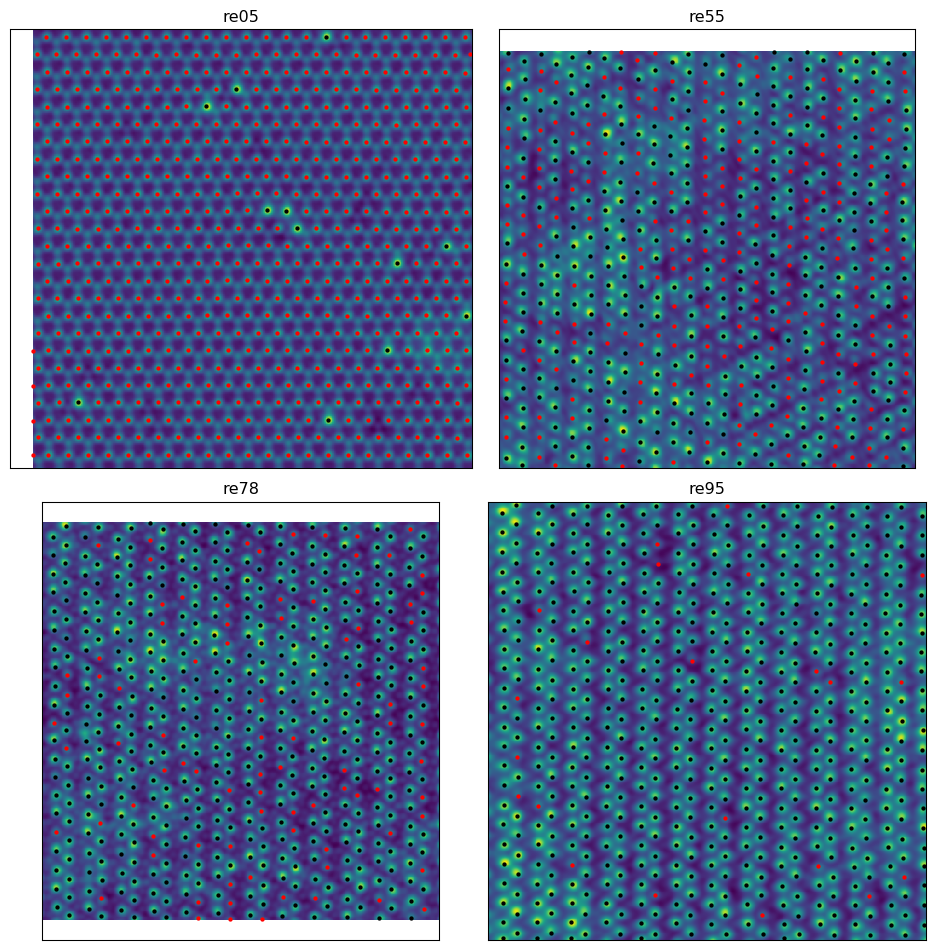

In [14]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), dpi = 96)

for i, (name, img, apos, aids) in enumerate(zip(names, intensities, atom_pos, atom_ids)):
    ir, ic = divmod(i, 2)
    axs[ir, ic].imshow(img)#, cmap = 'hot')
    axs[ir, ic].scatter(apos[aids==0,1], apos[aids==0,0], c = 'r', s = 5)
    axs[ir, ic].scatter(apos[aids==1,1], apos[aids==1,0], c = 'k', s = 5)
    axs[ir, ic].get_xaxis().set_visible(False)
    axs[ir, ic].get_yaxis().set_visible(False)
    axs[ir, ic].set_title(name)

plt.tight_layout()
plt.show()

**Function to calculate atom-atom distances**

In [15]:
def dist_calc(pt, pts):
    """Distance between a point 'pt' and a list of points 'pts'"""
    
    distances = []
    for ind in range(pts.shape[0]):
        distances.append((np.sqrt((pt[0] - pts[ind,0])**2 + (pt[1] - pts[ind,1])**2), ind))
    
    return distances

**Make hexagon neighbor configuration more regular for further analysis of pair relations**

In [16]:
def hexagon(pos):
    """
    Scale neighbor positions so that they have the same distance from their center of mass.
    """
    
    com_x = sum([p[0] for p in pos])/len(pos)
    com_y = sum([p[1] for p in pos])/len(pos)
    
    pos_hex = []
    for p in pos:
        dx = p[0] - com_x
        dy = p[1] - com_y
        r = (dx*dx + dy*dy)**0.5
        pos_hex.append([dx/r, dy/r])
    
    return pos_hex

**Configuration classification function**

In [17]:
def classify(pos, ids):
    """
    Assign unique identifiers to the neighbor configurations
    """
    
    # scale to make the neighbor hexagon more regular
    pos = hexagon(pos)
    
    # collect pair distances between neighbors and add the pair type (0, 1, 2)
    pair_list = []
    for i in range(len(pos)):
        for j in range(i+1, len(pos)):
            r = np.sqrt((pos[i][0]-pos[j][0])**2 + (pos[i][1]-pos[j][1])**2)
            pair_list.append((r, ids[i]+ids[j]))
    
    assert len(pair_list) == 15, f'Wrong number of pair distances: {len(pair_list)}'
    
    # number of Re atoms in the neighbor list
    n_atom = sum([1 for elem in ids if elem == 1])
    
    # sort the pair list according to distances
    pair_list = sorted(pair_list, key=lambda x: x[0])
    
    # number of Re-Re pairs among the 6 shortest distances distances (ortho)
    n_ortho = sum([1 for elem in pair_list[0:6] if elem[1] == 2])
    
    # number of Re-Re pairs among the 6 medium distances distances (meta)
    n_meta = sum([1 for elem in pair_list[6:12] if elem[1] == 2])
    
    # number of Re-Re pairs among the 3 longest distances distances (para)
    n_para = sum([1 for elem in pair_list[12:15] if elem[1] == 2])

    return [n_atom, n_ortho, n_meta, n_para]

**Collect histograms of all possible configurations**

In [18]:
from collections import Counter

# Image specific distance thresholds
dist_thres = [45, 32, 30, 26]

target_hist = {}

# cycle over lists of atoms from different images
for name, apos, aids, dthres in zip(names, atom_pos, atom_ids, dist_thres):

    configs = []
    
    # for each atom, find its neighbors, center it
    for i, (c_pos, c_id) in enumerate(zip(apos, aids)):
        
        x, y = c_pos
        distances = dist_calc([x, y], apos)

        neighbor_i = []
        neighbor_pos = []
        neighbor_id = []
        for k in range(len(distances)):
            if distances[k][0] <= dthres and distances[k][0] > 0:
                j = distances[k][1]
                neighbor_i.append(j)
                neighbor_pos.append(apos[j])
                neighbor_id.append(aids[j])
        
        if len(neighbor_i) < 6:
            continue
            
        assert len(neighbor_i) == 6, f"Incorrect number of neighbors: {len(neighbor_i)}, {name}"
        
        # classify configurations - assign unique ids based on counts of ortho, meta, and para distances
        configs.append(tuple([c_id] + classify(neighbor_pos, neighbor_id)))
            
    # get counts of distinct configuraions
    counts = Counter(configs)
    print('Number of configuration types:', len(counts))
    print('Total number of configurations (atoms with 6 neighbors):', sum(counts.values()))#, counts)
    target_hist[name] = counts

Number of configuration types: 8
Total number of configurations (atoms with 6 neighbors): 464
Number of configuration types: 25
Total number of configurations (atoms with 6 neighbors): 466
Number of configuration types: 13
Total number of configurations (atoms with 6 neighbors): 434
Number of configuration types: 6
Total number of configurations (atoms with 6 neighbors): 471


**Create a set of all dictinct configurations found in the four images**

In [19]:
cfg_list = [c for h in target_hist.values() for c in h]
cfg_types = sorted(set(cfg_list))
print('Number of distinct configurations:', len(cfg_types))

Number of distinct configurations: 26


In [20]:
x_re = {}
for name in names:
    re_sum = sum([v for k, v in target_hist[name].items() if k[0]==1])
    mo_sum = sum([v for k, v in target_hist[name].items() if k[0]==0])
    c = re_sum/(re_sum + mo_sum)
    x_re[name] = c

print(x_re.values())

dict_values([0.021551724137931036, 0.5965665236051502, 0.8433179723502304, 0.9575371549893843])


**Plot configuration histograms for different images**

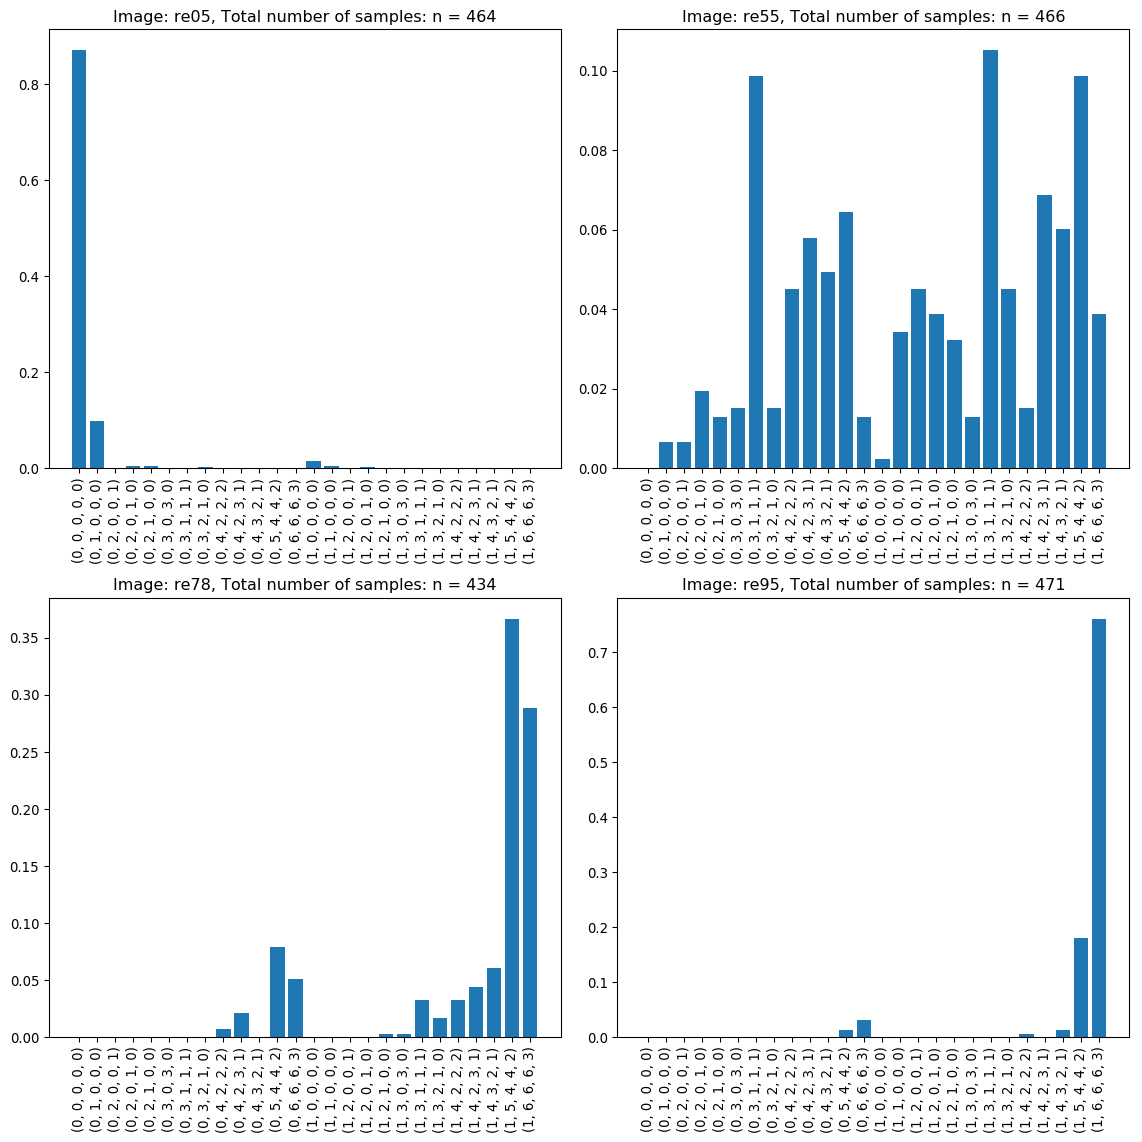

In [21]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), dpi = 96)

cfg_labels = [str(c) for c in cfg_types]
num_samples = {}
for i, name in enumerate(names):
    counts = target_hist[name]
    all_counts = np.array([counts.get(cfg, 0) for cfg in cfg_types])
    n_sample = np.sum(all_counts)
    num_samples[name] = n_sample
    all_counts = all_counts/float(n_sample)

    ir, ic = divmod(i, 2)
    axs[ir, ic].bar(cfg_labels, all_counts)
    axs[ir, ic].set_xticklabels(cfg_labels, rotation=90.0)
    axs[ir, ic].set_title('Image: ' + name + ', Total number of samples: n = ' + str(n_sample))
    
plt.tight_layout()
plt.show()

## Assign configuration ID from simulations to ID from image analysis

In [22]:
from itertools import product
from collections import Counter

# Neighbor hexagon positions
neighbor_pos = [
    [1.0, 0.0],
    [-1.0, 0.0],
    [ np.cos(np.pi/3.0),  np.sin(np.pi/3.0)],
    [-np.cos(np.pi/3.0),  np.sin(np.pi/3.0)],
    [ np.cos(np.pi/3.0), -np.sin(np.pi/3.0)],
    [-np.cos(np.pi/3.0), -np.sin(np.pi/3.0)],
]

conf_dict = {}

i = 0
for c_id in range(2): # pick center atom type                                           
    dx = c_id                                                                           
    for neighbor_id in product((0, 1), repeat=6):

        conf_id = tuple([c_id] + classify(neighbor_pos, neighbor_id))
            
        i += 1                                                      
        conf_dict[i] = conf_id

conf_counts = Counter(conf_dict.values())

In [23]:
# random configuration probabilities

ntot = 7 # number of atoms in the configuration

prob_conf = {}
for name in names:
    x = x_re[name]
    p_c = {}
    for k, v in conf_counts.items():
        
        # number of Re atoms in the configuration
        n_re = k[0] + k[1]
        
        #probability of a configuration with n_re atoms
        prob = x**n_re * (1.0-x)**(ntot - n_re)
        
        # weight probability by symmetry numbers (v)
        p_c[k] = prob*v
            
    prob_conf[name] = p_c

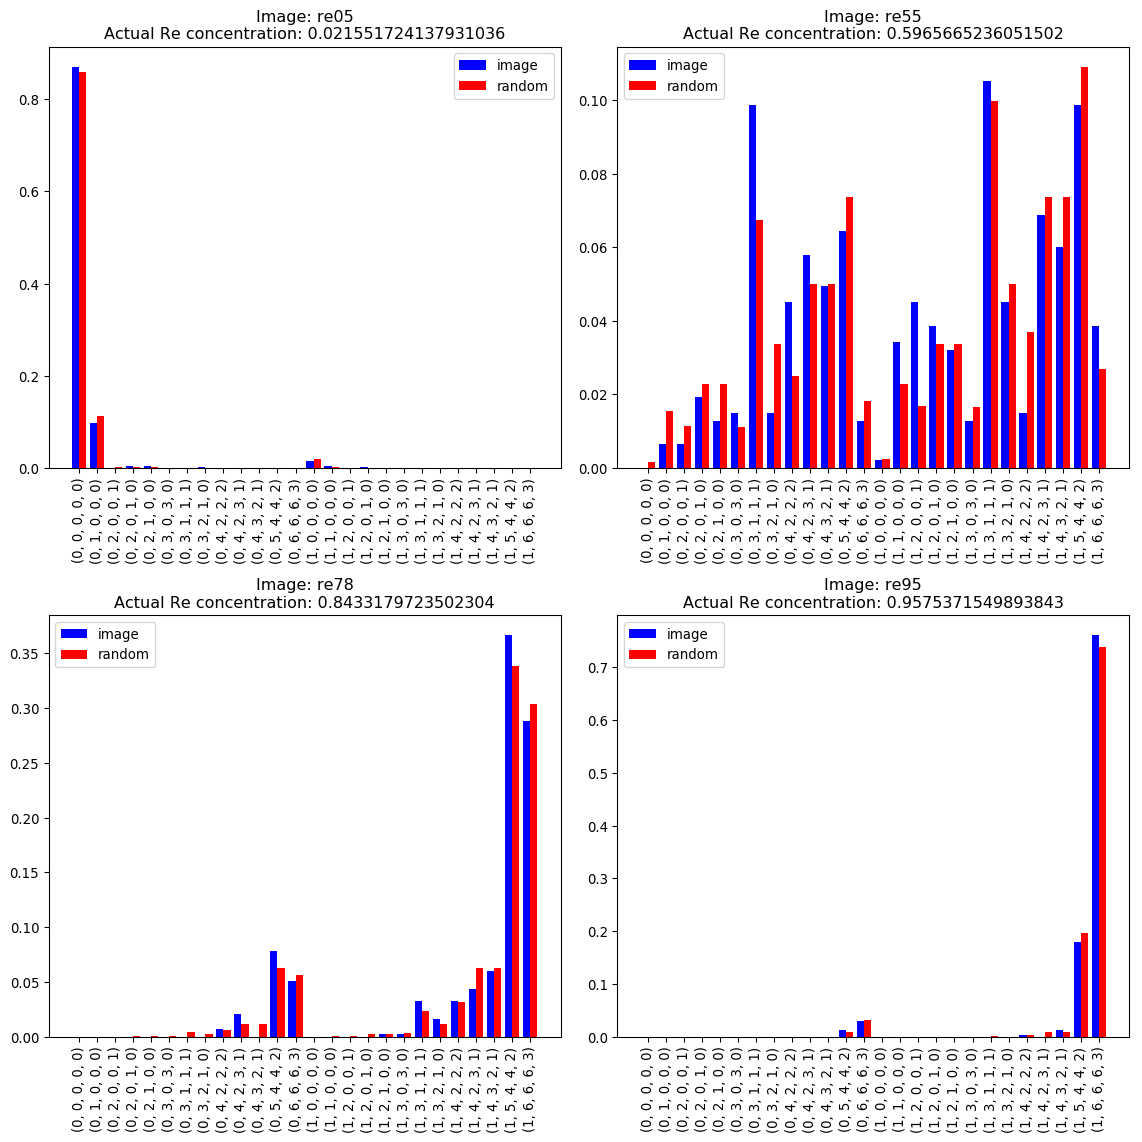

In [24]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), dpi = 96)

cfg_labels = [str(c) for c in cfg_types]
for i, name in enumerate(names):
    counts = target_hist[name]
    p_conf = prob_conf[name]
    all_counts = np.array([counts.get(cfg, 0) for cfg in cfg_types])
    n_sample = np.sum(all_counts)
    all_counts = all_counts/float(n_sample)

    p_array = [(k, v) for k, v in p_conf.items()]
    #cft_labels = [str(k[0]) for k in p_array]
    #all_counts_p = [float(k[1]) for k in p_array]
    all_counts_p = np.array([prob_conf[name].get(cfg, 0) for cfg in cfg_types])

    
    nconf = len(cfg_labels)
    width = 0.4

    ir, ic = divmod(i, 2)
    axs[ir, ic].bar(np.arange(nconf)-0.2, all_counts, width, color='b', label='image')
    axs[ir, ic].bar(np.arange(nconf)+0.2, all_counts_p, width, color='r', label='random')
    axs[ir, ic].legend()
    axs[ir, ic].set_xticks(range(nconf))
    axs[ir, ic].set_xticklabels(cfg_labels, rotation=90.0)
    axs[ir, ic].set_title('Image: ' + name + '\nActual Re concentration: ' + str(x_re[name]))#', Total number of samples: n = ' + str(n_sample))
    
plt.tight_layout()
plt.show()

In [25]:
# create a list of unique configurations using the symmetries of the hexagonal system (should give 26 configurations)
conf_list = sorted(list(set(conf_dict.values()))) # row index
nrows = len(conf_list) 
ncols = len(conf_dict)
print("Number of original configurations", ncols)
print('Number of symmetrized configurations:', nrows)

# Make transformation matrix from old (128) to new histogram (26)
trans_hist = np.zeros((nrows, ncols), dtype=float)
for key, val in conf_dict.items():
    # find index for the first occurence of the value
    #row = [i for i, e in enumerate(conf_list) if e == val][0]
    row = conf_list.index(val)
    col = key - 1
    trans_hist[row, col] = 1.0

Number of original configurations 128
Number of symmetrized configurations: 26


## Create Jeffrey's priors and adjust target histograms

In [65]:
# random configuration probabilities

ntot = 7 # number of atoms in the configuration

prob_conf = {}
for name in names:
    x = x_re[name]
    p_c = {}
    for k, v in conf_counts.items():

        # number of Re atoms in the configuration
        n_re = k[0] + k[1]

        #probability of a configuration with n_re atoms
        prob = x**n_re * (1.0-x)**(ntot - n_re)

        # weight probability by symmetry numbers (v)
        p_c[k] = prob*v

    prob_conf[name] = p_c

In [69]:
prob_conf['re05']

{(0, 0, 0, 0, 0): 0.8585490383627009,
 (0, 1, 0, 0, 0): 0.11346463062062129,
 (0, 2, 1, 0, 0): 0.0024992209387802045,
 (0, 2, 0, 1, 0): 0.0024992209387802045,
 (0, 2, 0, 0, 1): 0.0012496104693901023,
 (0, 3, 1, 1, 1): 0.00011009783871278435,
 (0, 4, 2, 2, 2): 6.062656316783279e-07,
 (0, 3, 2, 1, 0): 5.5048919356392175e-05,
 (0, 4, 3, 2, 1): 1.2125312633566558e-06,
 (0, 3, 0, 3, 0): 1.8349639785464058e-05,
 (0, 4, 2, 3, 1): 1.2125312633566558e-06,
 (0, 5, 4, 4, 2): 2.6707737078340445e-08,
 (0, 6, 6, 6, 3): 9.80460245166683e-11,
 (1, 0, 0, 0, 0): 0.018910771770103547,
 (1, 1, 0, 0, 0): 0.0024992209387802045,
 (1, 2, 1, 0, 0): 5.5048919356392175e-05,
 (1, 2, 0, 1, 0): 5.5048919356392175e-05,
 (1, 2, 0, 0, 1): 2.7524459678196087e-05,
 (1, 3, 1, 1, 1): 2.4250625267133115e-06,
 (1, 4, 2, 2, 2): 1.3353868539170222e-08,
 (1, 3, 2, 1, 0): 1.2125312633566558e-06,
 (1, 4, 3, 2, 1): 2.6707737078340445e-08,
 (1, 3, 0, 3, 0): 4.0417708778555194e-07,
 (1, 4, 2, 3, 1): 2.6707737078340445e-08,
 (1, 5, 

In [84]:
# total number of configurations
n_conf = sum([v for v in conf_counts.values()])
multiple = [conf_counts[cfg] for cfg in cfg_types]


for name in names:
    t_hist = [target_hist[name].get(cfg, 0) for cfg in cfg_types]
    probs = [prob_conf[name].get(cfg, 0) for cfg in cfg_types]

    #print(probs)
    n_tot = sum(t_hist)
    #print(n_tot, t_hist)
    #print(multiple)
    
    # apply multinomial Jeffrey's prior
    #t_adjusted = [n_tot*(nc + mult/2)/(n_tot + n_conf/2) for nc, mult, p in zip(t_hist, multiple, probs)]
    t_adjusted = [n_tot*(nc + p*n_conf/2)/(n_tot + n_conf/2) for nc, mult, p in zip(t_hist, multiple, probs)]

    print(np.array([(t_orig, round(t, 10), n_tot*p) for t_orig, t, p in zip(t_hist, t_adjusted, probs)]))
    #print(t_hist)
    #print(t_adjusted)

[[4.04000000e+02 4.03317182e+02 3.98366754e+02]
 [4.50000000e+01 4.59269804e+01 5.26475886e+01]
 [0.00000000e+00 7.02811222e-02 5.79819258e-01]
 [2.00000000e+00 1.89813800e+00 1.15963852e+00]
 [2.00000000e+00 1.89813800e+00 1.15963852e+00]
 [0.00000000e+00 1.03202820e-03 8.51423286e-03]
 [0.00000000e+00 6.19216940e-03 5.10853972e-02]
 [1.00000000e+00 8.81883963e-01 2.55426986e-02]
 [0.00000000e+00 3.40978000e-05 2.81307253e-04]
 [0.00000000e+00 6.81957000e-05 5.62614506e-04]
 [0.00000000e+00 6.81957000e-05 5.62614506e-04]
 [0.00000000e+00 1.50210000e-06 1.23923900e-05]
 [0.00000000e+00 5.50000000e-09 4.54933554e-08]
 [7.00000000e+00 7.21510280e+00 8.77459810e+00]
 [2.00000000e+00 1.89813800e+00 1.15963852e+00]
 [0.00000000e+00 1.54804230e-03 1.27713493e-02]
 [1.00000000e+00 8.81883963e-01 2.55426986e-02]
 [0.00000000e+00 3.09608470e-03 2.55426986e-02]
 [0.00000000e+00 2.27319000e-05 1.87538169e-04]
 [0.00000000e+00 1.36391400e-04 1.12522901e-03]
 [0.00000000e+00 6.81957000e-05 5.626145

In [109]:
from scipy import stats
import numpy as np
x = np.array([1,1,1])
mu = np.array([0,0,0])
sigma = np.array([[1,0,0],[0,1,0],[0,0,1]])
# m_dist_x = np.dot((x-mu).transpose(),np.linalg.inv(sigma))
# m_dist_x = np.dot(m_dist_x, (x-mu))
s2 = (x-mu).T.dot(np.linalg.inv(sigma)).dot((x-mu))
print(s2)
s2 = 0.0647
1-stats.chi2.cdf(460*2*s2, 25)

3.0


0.00012156149437525521

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), dpi = 96)

cfg_labels = [str(c) for c in cfg_types]
for i, name in enumerate(names):
    counts = target_hist[name]
    p_conf = prob_conf[name]
    all_counts = np.array([counts.get(cfg, 0) for cfg in cfg_types])
    n_sample = np.sum(all_counts)
    all_counts = all_counts/float(n_sample)

    p_array = [(k, v) for k, v in p_conf.items()]
    #cft_labels = [str(k[0]) for k in p_array]
    #all_counts_p = [float(k[1]) for k in p_array]
    all_counts_p = np.array([prob_conf[name].get(cfg, 0) for cfg in cfg_types])

    
    nconf = len(cfg_labels)
    width = 0.4

    ir, ic = divmod(i, 2)
    axs[ir, ic].bar(np.arange(nconf)-0.2, all_counts, width, color='b', label='image')
    axs[ir, ic].bar(np.arange(nconf)+0.2, all_counts_p, width, color='r', label='random')
    axs[ir, ic].legend()
    axs[ir, ic].set_xticks(range(nconf))
    axs[ir, ic].set_xticklabels(cfg_labels, rotation=90.0)
    axs[ir, ic].set_title('Image: ' + name + '\nActual Re concentration: ' + str(x_re[name]))#', Total number of samples: n = ' + str(n_sample))
    
plt.tight_layout()
plt.show()

In [65]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
from scipy.optimize import fmin

sys.path.append('../../../force_fields/statmechlib')
from statmechlib.read_write import read_lattice_model, read_modeldef, write_modeldef
from statmechlib.preprocessing import get_stats_latt
from statmechlib.forcefields import sd2

from subprocess import Popen, PIPE
import multiprocessing as mp

In [28]:
sim_dir = '../src/code'

In [29]:
# read reference system parameters into an array
def read_mld(data_paths):
    pars_ref = {}
    for data_path in data_paths:
        params = read_modeldef(os.path.join(data_path, 'lg.mld'))
        pars_ref[data_path] = np.array([v for v in params['ref_params'].values()]).flatten(order='F')

    # check if the force field parameters agree between systems
    assert len(set([str(v) for v in pars_ref.values()])) == 1, "Different parameters"

    return pars_ref[data_paths[0]]

In [30]:
# read lattice simulation results: configuration statistics and energies
def read_outputs(names, dirnames):
    trjs = {}
    for name, dname in zip(names, dirnames):
        trjs[name] = read_lattice_model(dname)
    return trjs

In [31]:
# filter the results (discard initial imin number of configurations)
def trajectory_range(trjs, imin=10):

    for key in trjs.keys():
        trjs[key]['energy'] = trjs[key]['energy'][imin:]
        trjs[key]['temp'] = trjs[key]['temp'][imin:]
        trjs[key]['interaction_stats'] = trjs[key]['interaction_stats'][imin:]
        trjs[key]['config_stats'] = trjs[key]['config_stats'][imin:]

    return trjs


In [32]:
def make_reference_histograms(trjs):
    """
    For given trajectories, convert to histograms of symmetrized configurations
    """
    # group symmetric configurations collected from a simulated system based on their unique label
    hsv = {}
    for name, trj in trjs.items():
        # convert to the histograms of symmetrized configurations
        old_hist = np.array(trj['config_stats'])
        hsv[name] = trans_hist.dot(old_hist.T).T
        # normalize = calculate relative frequencies of symmetrized configurations
        for i in range(hsv[name].shape[0]):
            sm = np.sum(hsv[name][i,:])
            hsv[name][i,:] = hsv[name][i,:]/sm

    return hsv

In [33]:
# filter the results (discard initial configurations)
def make_energy_statistics(trjs):
    hsu = {}
    for name, trj in trjs.items():
        # flatten the array column by column (Fortran style 'F')
        hsu[name] = np.array([np.array(ar).flatten(order='F') for ar in trj['interaction_stats']])
    return hsu

In [34]:
# get relative frequencies of symmetrized surface local configurations averaged over all 'image' configurations
def make_average_histograms(names):
    hsv_ave = {}
    for name in names:
        histave = []
        for i in range(hsv[name].shape[1]):
            histave.append(sum(hsv[name][:,i])/float(hsv[name].shape[0]))
        hsv_ave[name] = np.array(histave)

    return hsv_ave

In [35]:
# Assemble target data structures
def make_targets(gsv, num_samples):
    targets = {}
    for name in gsv.keys():
        # target
        targ = {}
        targ['config_stats'] = gsv[name]
        targ['weight'] = num_samples[name]/sum(num_samples.values())
        targets[name] = targ

    return targets

In [36]:
# Assemble reference data structures
def make_stats(trjs, hsu, hsv):
    stats = {}
    for name in trjs.keys():
        # reference data
        stat = {}
        stat['config_stats'] = hsv[name]
        stat['interaction_stats'] = hsu[name]
        stat['energy'] = np.array(trjs[name]['energy'])
        stat['temp'] = np.array(trjs[name]['temp'])
        stats[name] = stat

    return stats

hsv_ave = make_average_histograms(names)

# compare simulated statistics with target and random histograms
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), dpi = 96)

cfg_labels = [str(c) for c in cfg_types]
gsv = {}
for i, name in enumerate(names):
    counts = target_hist[name]
    #p_conf = prob_conf[name]
    all_counts = np.array([counts.get(cfg, 0) for cfg in cfg_types])
    n_sample = np.sum(all_counts)
    all_counts = all_counts/float(n_sample)
    gsv[name] = all_counts
    all_counts_p = np.array([prob_conf[name].get(cfg, 0) for cfg in cfg_types])

    nconf = len(cfg_labels)
    width = 0.2

    ir, ic = divmod(i, 2)
    axs[ir, ic].bar(np.arange(nconf)-0.2, np.arcsin(np.sqrt(all_counts)), width, color='b', label='experiment')
    axs[ir, ic].bar(np.arange(nconf)+0.0, np.arcsin(np.sqrt(all_counts_p)), width, color='r', label='random')
    axs[ir, ic].bar(np.arange(nconf)+0.2, np.arcsin(np.sqrt(hsv_ave[name])), width, color='y', label='model')
    axs[ir, ic].set_xticks(range(nconf))
    axs[ir, ic].set_xticklabels(cfg_labels, rotation=90.0)
    axs[ir, ic].set_title('Image: ' + name)# + ', Total number of samples: n = ' + str(n_sample))
    axs[ir, ic].set_xlabel('configuration ID')
    axs[ir, ic].set_ylabel(r'$\arcsin\sqrt{p}$')
    axs[ir, ic].legend()

plt.tight_layout()
plt.show()

In [37]:
gsv = {}
for i, name in enumerate(names):
    counts = target_hist[name]
    all_counts = np.array([counts.get(cfg, 0) for cfg in cfg_types])
    n_sample = np.sum(all_counts)
    all_counts = all_counts/float(n_sample)
    gsv[name] = all_counts

In [38]:
def optimize_params(data):#par_in, stat, target):
    par_in = data['params']
    stat = data['stats']
    target = data['targets']
    print('# Start sd2 =', sd2(par_in, stat, target))
    print('# Starting parameters:', par_in)
    output = fmin(sd2, par_in, args=(stat, target), maxiter=100000, maxfun=10000, disp=0, full_output=1)
    print('\n# End sd2 =', output[1])
    p_out = output[0]
    print('# Final parameters:', p_out)
    return p_out, output[1]

In [39]:
# define data sets for which parameters will be optimized
from itertools import combinations
# full set of systems
datasets = {0:tuple(names)}
# partial sets of systems
datasets.update({i:s for i, s in enumerate(combinations(names, 3), 1)})
#datasets = {0:('re55',)}
print(datasets)

{0: ('re05', 're55', 're78', 're95'), 1: ('re05', 're55', 're78'), 2: ('re05', 're55', 're95'), 3: ('re05', 're78', 're95'), 4: ('re55', 're78', 're95')}


In [46]:
# number of optimization iterations
n_iter = 5
for it in range(n_iter):
    
    input_data = []
    for key in range(len(datasets)):
    #for key, dset in datasets.items():
        dset = datasets[key]
        
        # directory names
        dirnames = [str(key) + '_' + s for s in dset]
        data_paths = [os.path.join(sim_dir, dname) for dname in dirnames]

        # get reference parameters
        pars_ref = read_mld(data_paths)
        pars_in = np.array([pars_ref[1], pars_ref[4]])
        
        # read reference data
        trjs = read_outputs(dset, data_paths)
        
        #pool = mp.Pool()
        #trj_list = pool.map(read_lattice_model, data_paths)
        #trjs = dict(zip(dset, trj_list))
        
        # select the equilibrated part of the trajectories
        trjs = trajectory_range(trjs, imin=1000)
        
        # get histograms of symmetrized configurations
        hsv = make_reference_histograms(trjs)

        # get statistics of for lattice model energetics
        hsu = make_energy_statistics(trjs)
        
        # make targets and statistics for optimization with selected names
        targets = make_targets(gsv, num_samples)
        stats = make_stats(trjs, hsu, hsv)
        print(stats.keys())
        
        # select statistics and targets relevant for dset 
        stats_opt = {s:stats[s] for s in dset}
        targets_opt = {s:targets[s] for s in dset}
        
        # optimize parameters
        input_data.append({'params':pars_in, 'stats':stats_opt, 'targets':targets_opt})

        #oputput_data = optimize_params(input_data)#pars_in, stats_opt, targets_opt)

    pool = mp.Pool()
    output_data = pool.map(optimize_params, input_data)

    # write model definition files with new parameters
    for key in range(len(datasets)):
        dset = datasets[0] # make parameter files for _all_ systems
        
        # directory names
        dirnames = [str(key) + '_' + s for s in dset]
        data_paths = [os.path.join(sim_dir, dname) for dname in dirnames]

        # set new parameters
        p_out = output_data[key][0]
        pars = [0., p_out[0], 0., 0., p_out[1], 0.]

        # write model definition file into a simulation directory
        for data_path in data_paths:
            write_modeldef(os.path.join(data_path, 'lg.mld'), pars)

    # run simulations
    original_dir = os.getcwd()
    # go to simulation directory
    os.chdir(sim_dir)
    
    for key in range(len(datasets)):
        dset = datasets[0] # run simulations for _all_ systems

        # directory names
        dirnames = [str(key) + '_' + s for s in dset]
    
        proc_list = []
        fout_list = []

        for name, dname in zip(dset, dirnames):
            os.chdir('./'+dname)
        
            fout = open('lg.run', 'w')
            fin = open(name+'.inp', 'r')
        
            proc_list.append(Popen('./lg', stdin=fin, stdout=fout, stderr=PIPE))
        
            fin.close()
            fout_list.append(fout) 
            os.chdir('..')

        for proc, fout in zip(proc_list, fout_list):
            proc.wait()
            fout.close()
    
    # go back to notebook directory
    os.chdir(original_dir)

Reading ../src/code/0_re55/lg.hst
Reading ../src/code/0_re55/lg.run
dict_keys(['re55'])
# Start sd2 = 0.007543033612003143
# Starting parameters: [ 0.10573289 -0.45494785]

# End sd2 = 0.006666081262414821
# Final parameters: [ 0.98956388 -2.00561043]
Reading ../src/code/0_re55/lg.hst
Reading ../src/code/0_re55/lg.run
dict_keys(['re55'])
# Start sd2 = 0.03179131543261352
# Starting parameters: [ 0.98956388 -2.00561043]

# End sd2 = 0.024754397064857298
# Final parameters: [-2.4010647   2.39716989]
Reading ../src/code/0_re55/lg.hst
Reading ../src/code/0_re55/lg.run
dict_keys(['re55'])
# Start sd2 = 0.10600531945839334
# Starting parameters: [-2.4010647   2.39716989]

# End sd2 = 0.10600531945839334
# Final parameters: [-2.4010647   2.39716989]


Process ForkPoolWorker-19:
Process ForkPoolWorker-23:
Process ForkPoolWorker-24:
Process ForkPoolWorker-22:
Process ForkPoolWorker-17:
Process ForkPoolWorker-21:
Process ForkPoolWorker-18:
Process ForkPoolWorker-16:
Process ForkPoolWorker-12:
Process ForkPoolWorker-14:
Process ForkPoolWorker-9:
Process ForkPoolWorker-20:
Process ForkPoolWorker-6:
Process ForkPoolWorker-4:
Process ForkPoolWorker-5:
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Process ForkPoolWorker-11:
Process ForkPoolWorker-8:
Process ForkPoolWorker-15:
Process ForkPoolWorker-7:
Process ForkPoolWorker-13:
Process ForkPoolWorker-10:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (

  File "/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 95, i

KeyboardInterrupt: 

Process ForkPoolWorker-46:
Process ForkPoolWorker-41:
Process ForkPoolWorker-26:
Process ForkPoolWorker-28:
Process ForkPoolWorker-47:
Process ForkPoolWorker-44:
Process ForkPoolWorker-32:
Process ForkPoolWorker-37:
Process ForkPoolWorker-30:
Process ForkPoolWorker-45:
Process ForkPoolWorker-31:
Process ForkPoolWorker-34:
Process ForkPoolWorker-39:
Process ForkPoolWorker-29:
Process ForkPoolWorker-25:
Process ForkPoolWorker-27:
Process ForkPoolWorker-43:
Process ForkPoolWorker-40:
Process ForkPoolWorker-36:
Process ForkPoolWorker-42:
Process ForkPoolWorker-33:
Process ForkPoolWorker-48:
Process ForkPoolWorker-35:
Process ForkPoolWorker-38:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Tr

  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/anaconda3/lib/python3.6

0.07051797 -0.27910435

0.02054406 -0.50064873

0.06463121 -0.22251215 0.018662095932150156

0.02972088 -0.30352361 0.018200443606690948

0.10573289 -0.45494785 0.01816080620437813

In [41]:
pwd

'/Users/l2v/work/images/mos2/notebooks'

In [40]:
datasets[0]

('re05', 're55', 're78', 're95')

In [54]:
from scipy.stats import norm

dset = datasets[0]
input_data = []

for key in ['r_', '0_']:

    # directory names
    dirnames = [key + s for s in dset]
    data_paths = [os.path.join(sim_dir, dname) for dname in dirnames]

    # get reference parameters
    pars_ref = read_mld(data_paths)
    pars_in = np.array([pars_ref[1], pars_ref[4]])
        
    # read reference data
    trjs = read_outputs(dset, data_paths)

    #pool = mp.Pool()
    #trj_list = pool.map(read_lattice_model, data_paths)
    #trjs = dict(zip(dset, trj_list))
        
    # select the equilibrated part of the trajectories
    trjs = trajectory_range(trjs, imin=1000)
        
    # get histograms of symmetrized configurations
    hsv = make_reference_histograms(trjs)
    for key, val in hsv.items():
        print('hsv.shape', key, val.shape)
        print('n_eff:', n_effective(val))

    # get statistics of for lattice model energetics
    hsu = make_energy_statistics(trjs)
        
    # make targets and statistics for optimization with selected names
    targets = make_targets(gsv, num_samples)
    stats = make_stats(trjs, hsu, hsv)
    print(stats.keys())

    # select statistics and targets relevant for dset 
    stats_opt = {s:stats[s] for s in dset}
    targets_opt = {s:targets[s] for s in dset}
        
    # optimize parameters
    input_data.append({'params':pars_in, 'stats':stats_opt, 'targets':targets_opt})
        
    s2 = sd2(pars_in, stats_opt, targets_opt)
    print('----MODEL:', key, '-----')
    print('Total statistical distance: ', s2)
    z_coeff = np.sqrt(460.0*s2/2.0)
    print('z-coeff:', z_coeff)
    p_value = norm.sf(z_coeff)
    print('p-value:', p_value)

    for s in dset:
        stats_opt = {s:stats[s]} 
        targets_opt = {s:targets[s]}
        
        s2 = sd2(pars_in, stats_opt, targets_opt)
        print(f'Statistical distance for {s}: ', s2)
        z_coeff = np.sqrt(460.0*s2/2.0)
        print('z-coeff:', z_coeff)
        p_value = norm.sf(z_coeff)
        print('p-value:', p_value)

Reading ../src/code/r_re55/lg.hst
Reading ../src/code/r_re55/lg.run
hsv.shape re55 (39001, 26)
n_eff: 2097.8423525777343
dict_keys(['re55'])
----MODEL: re55 -----
Total statistical distance:  0.0082469666962364
z-coeff: 1.3772444736263683
p-value: 0.08421833801765571
Statistical distance for re55:  0.0082469666962364
z-coeff: 1.3772444736263683
p-value: 0.08421833801765571
Reading ../src/code/0_re55/lg.hst
Reading ../src/code/0_re55/lg.run
hsv.shape re55 (39001, 26)
n_eff: 2156.1502178957858
dict_keys(['re55'])
----MODEL: re55 -----
Total statistical distance:  0.007800196474996424
z-coeff: 1.3394197210916292
p-value: 0.09021703641186335
Statistical distance for re55:  0.007800196474996424
z-coeff: 1.3394197210916292
p-value: 0.09021703641186335


In [91]:
from scipy.stats import norm

dset = datasets[0]
input_data = {}

for key in ['null_', 'r_', '0_m5_', '0_p5_', 'm5_0_', 'p5_0_']:
#for key in ['1_', '2_', '3_', '4_']:

    # directory names
    dirnames = [key + s for s in dset]
    data_paths = [os.path.join(sim_dir, dname) for dname in dirnames]

    # get reference parameters
    print(data_paths)
    pars_ref = read_mld(data_paths)
    pars_in = np.array([pars_ref[1], pars_ref[4]])
        
    #print(pars_ref)
    #print(pars_in)

    # read reference data
    trjs = read_outputs(dset, data_paths)

    #pool = mp.Pool()
    #trj_list = pool.map(read_lattice_model, data_paths)
    #trjs = dict(zip(dset, trj_list))
        
    # select the equilibrated part of the trajectories
    trjs = trajectory_range(trjs, imin=1000)
        
    # get histograms of symmetrized configurations
    hsv = make_reference_histograms(trjs)
    for key_hsv, val in hsv.items():
        #print(val[0])
        print('hsv.shape', key_hsv, val.shape)
        #print('n_eff:', n_effective(val))

    # get statistics of lattice model energetics
    hsu = make_energy_statistics(trjs)
        
    # make targets and statistics for optimization with selected names
    targets = make_targets(gsv, num_samples)
    stats = make_stats(trjs, hsu, hsv)

    # select statistics and targets relevant for dset 
    stats_opt = {s:stats[s] for s in dset}
    targets_opt = {s:targets[s] for s in dset}

    print(stats_opt.keys())
    print(targets_opt.keys())
    
    # optimize parameters
    input_data[key] = {'params':pars_in, 'stats':stats_opt, 'targets':targets_opt}

['../src/code/null_re05', '../src/code/null_re55', '../src/code/null_re78', '../src/code/null_re95']
Reading ../src/code/null_re05/lg.hst
Reading ../src/code/null_re05/lg.run
Reading ../src/code/null_re55/lg.hst
Reading ../src/code/null_re55/lg.run
Reading ../src/code/null_re78/lg.hst
Reading ../src/code/null_re78/lg.run
Reading ../src/code/null_re95/lg.hst
Reading ../src/code/null_re95/lg.run
hsv.shape re05 (39001, 26)
hsv.shape re55 (39001, 26)
hsv.shape re78 (39001, 26)
hsv.shape re95 (39001, 26)
dict_keys(['re05', 're55', 're78', 're95'])
dict_keys(['re05', 're55', 're78', 're95'])
['../src/code/r_re05', '../src/code/r_re55', '../src/code/r_re78', '../src/code/r_re95']
Reading ../src/code/r_re05/lg.hst
Reading ../src/code/r_re05/lg.run
Reading ../src/code/r_re55/lg.hst
Reading ../src/code/r_re55/lg.run
Reading ../src/code/r_re78/lg.hst
Reading ../src/code/r_re78/lg.run
Reading ../src/code/r_re95/lg.hst
Reading ../src/code/r_re95/lg.run
hsv.shape re05 (39001, 26)
hsv.shape re55 (390

In [93]:
input_data['m5_0_']['params']

array([-0.5,  0. ])

In [94]:
for key, in_data in input_data.items():
        
    pars_in = in_data['params']
    stats_opt = in_data['stats']
    targets_opt = in_data['targets']
        
    pars_in = np.array([0.0, 0.0])
    pars_in = np.array([ 0.10573289, -0.45494785])
    s2, s2_ref = sd2(pars_in, stats_opt, targets_opt)

    print('----MODEL:', key, '-----')
    print(pars_in)
    print('Total statistical distance: ', s2, s2_ref)
    z_coeff = np.sqrt(460.0*s2/2.0)
    print('z-coeff:', z_coeff)
    p_value = norm.sf(z_coeff)
    print('p-value:', p_value)

----MODEL: null_ -----
[ 0.10573289 -0.45494785]
Total statistical distance:  0.02283556183601203 1.9720751997472286e-05
z-coeff: 2.2917633434285416
p-value: 0.010959651493585701
----MODEL: r_ -----
[ 0.10573289 -0.45494785]
Total statistical distance:  0.01815918973256356 1.0935835391036636e-13
z-coeff: 2.0436765004495254
p-value: 0.02049275811123428
----MODEL: 0_m5_ -----
[ 0.10573289 -0.45494785]
Total statistical distance:  0.018346282901671538 1.1218054014786638e-05
z-coeff: 2.0541774673538926
p-value: 0.019979259211852743
----MODEL: 0_p5_ -----
[ 0.10573289 -0.45494785]
Total statistical distance:  0.04709924218676191 2.5273747760762218e-05
z-coeff: 3.2913258275283597
p-value: 0.0004985817198520792
----MODEL: m5_0_ -----
[ 0.10573289 -0.45494785]
Total statistical distance:  0.026076360936086215 2.3147332899994748e-05
z-coeff: 2.4489922448427293
p-value: 0.007162826627532864
----MODEL: p5_0_ -----
[ 0.10573289 -0.45494785]
Total statistical distance:  0.0977638961987256 2.3774120

In [86]:
ngrid = 50
scale = np.array([1.0, 1.0])

s2_profiles = {}
for key, in_data in input_data.items():
    stats_opt = in_data['stats']
    targets_opt = in_data['targets']
    s2_profiles[key] = np.empty((2*ngrid+1, 2*ngrid+1), dtype=float)
    it = 0
    for i, j in product(range(-ngrid, ngrid+1), repeat=2):
        x = float(i)/(ngrid)
        y = float(j)/(ngrid)
        pars = np.array([x, y])*scale
        s2, s2_ref = sd2(pars, stats_opt, targets_opt)
        #print(*pars, s2)
        s2_profiles[key][i+ngrid, j+ngrid] = s2
        it += 1
        if it % 1000 == 0:
            print(it)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [117]:
def get_profiles(data, ngrid=50, scale=[1.0, 1.0]):
    scale = np.array(scale)
    
    stats_opt = data[1]['stats']
    targets_opt = data[1]['targets']
    
    s2_prof = np.empty((2*ngrid+1, 2*ngrid+1), dtype=float)
    s2ref_prof = np.empty((2*ngrid+1, 2*ngrid+1), dtype=float)

    for i, j in product(range(-ngrid, ngrid+1), repeat=2):
        x = float(i)/(ngrid)
        y = float(j)/(ngrid)
        pars = np.array([x, y])*scale
        s2, s2ref = sd2(pars, stats_opt, targets_opt)
        s2_prof[i+ngrid, j+ngrid] = s2
        s2ref_prof[i+ngrid, j+ngrid] = s2ref

    return [data[0], s2_prof, s2ref_prof]

In [118]:
data = [(key, in_data) for key, in_data in input_data.items()]

pool = mp.Pool()
output_data = pool.map(get_profiles, data)

pool.close()
pool.join()

../../../force_fields/statmechlib/statmechlib/forcefields/lattgas.py:126: RuntimeWarning: invalid value encountered in true_divide
  eee /= np.sum(eee)
../../../force_fields/statmechlib/statmechlib/forcefields/lattgas.py:126: RuntimeWarning: invalid value encountered in true_divide
  eee /= np.sum(eee)


null_ 0.01780431031054326 0.03107856635213829
r_ 0.018132001512173587 0.025691704816133566
0_m5_ 0.017847898900055312 0.02878305445968854
0_p5_ nan nan
m5_0_ 0.020684181721229544 0.03977933470681151
p5_0_ nan nan


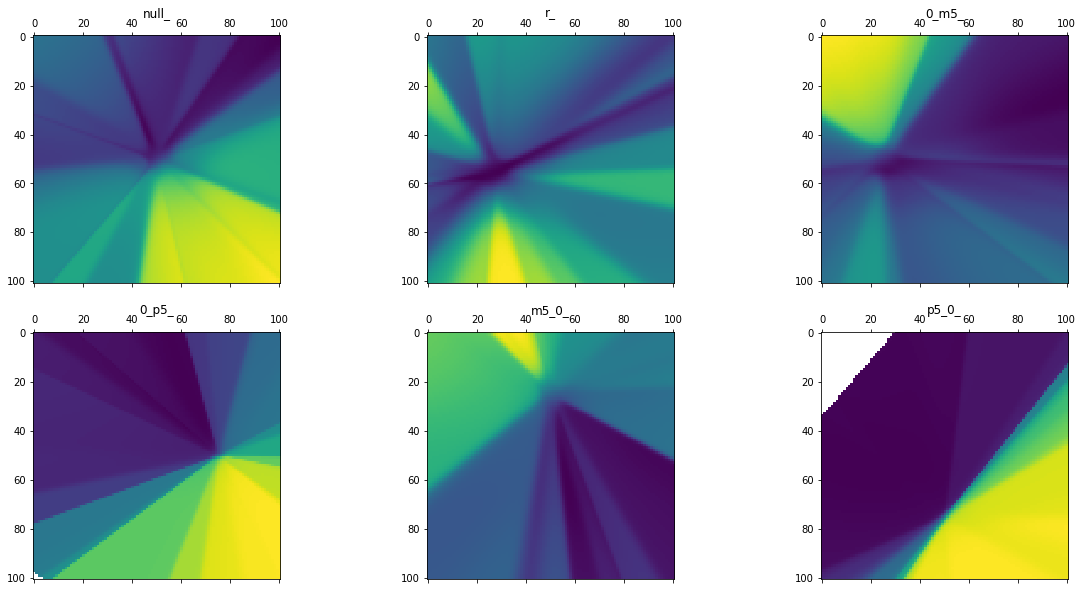

In [120]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
for i, out_data in enumerate(output_data):
    ir, ic = divmod(i, 3)
    im = axes[ir, ic].matshow(out_data[1])
    axes[ir, ic].set_title(out_data[0])
    print(out_data[0], np.min(out_data[1]), np.max(out_data[1]))
    #plt.colorbar(im)

null_ 0.0
r_ 1.1246446693935705e-07
0_m5_ 0.0
0_p5_ 0.0
m5_0_ 0.0
p5_0_ 0.0


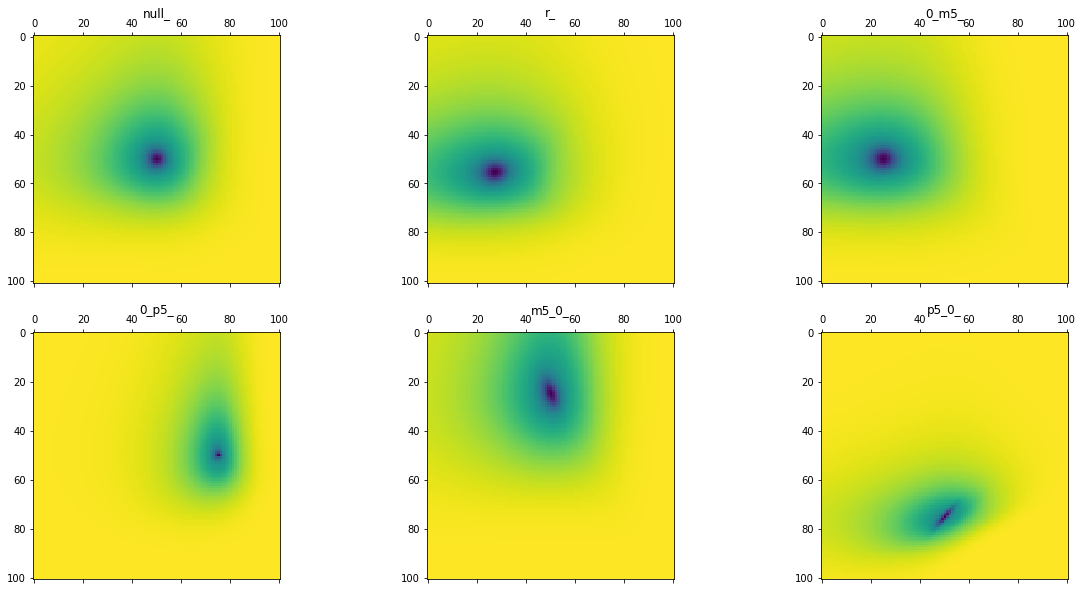

In [116]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
for i, out_data in enumerate(output_data):
    ir, ic = divmod(i, 3)
    im = axes[ir, ic].matshow(out_data[2])
    axes[ir, ic].set_title(out_data[0])
    print(out_data[0], np.min(out_data[2]))
    #plt.colorbar(im)

In [ ]:
#figure()
fig = figure(1, figsize =(9.0, 6.0), dpi=600)

xlab = r'$w_{0}$'
xlabel(xlab, fontsize=24.0)
ylab = r'$w_{1}$'
ylabel(ylab, fontsize=24.0)

origin = 'lower'
#levels = [0.5*h, 1.0*h, 1.5*h, 2.0*h, 2.5*h, 3.0*h, 3.5*h] 
levels = [float(i)*0.005 for i in range(20)]
CS3 = contourf(X[0:50,0:50], Y[0:50,0:50], D[0:50,0:50], levels, cmap=plt.cm.summer, origin=origin, extend='both')
CS3.cmap.set_bad(color='k')
CS3.cmap.set_under(color='k')
CS3.cmap.set_over(color='w')
#plot(sx[:], sy[:], 'w--', linewidth=2)
#plot([3.19802811517], [0.639564214485],'w+', markersize=12, mec='white', mew=2.0)
levels2 = [float(i)*0.005 for i in range(20)]
#levels2 = [float(i)*0.02 for i in range(120)]
CS4 = contour(X, Y, D, levels2, colors = ('r',), linewidths = (0.5,), origin = origin)
xmin = 0.529327
ymin = 0.02339039
plot([xmin], [ymin],'w+', markersize=12, mec='white', mew=2.0)
#xmin = 0.434
#ymin = 0.382
#plot([xmin], [ymin],'r+', markersize=12, mec='red', mew=2.0)
print 'params', xmin, ymin, ymin/4.184


#cbaxes = fig.add_axes([0.9, 0.9, 0.1, 0.9])
#colorbar(CS3, cax=cbaxes)
colorbar(CS3)
#axis([2.225, 4.225, 0.01, 1.0])
axis([0.30, 0.62, -0.15, 0.15])
gcf().subplots_adjust(bottom=0.12, right=0.75)

draw()
savefig('g2b')

Re05


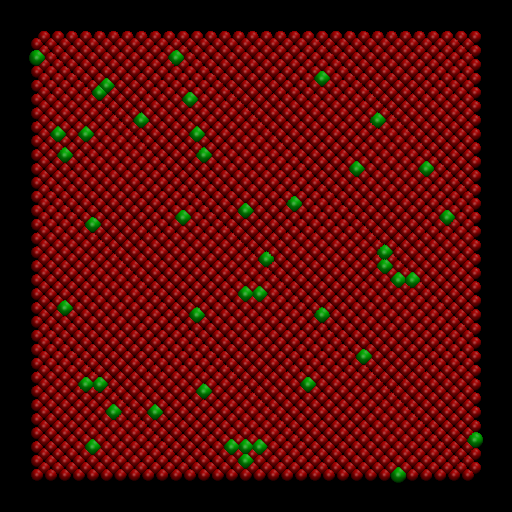

In [32]:
from IPython.display import Image
from IPython.core.display import HTML 

print('Re05')
Image("../reports/r05.png", width=300, height=300)

Re55


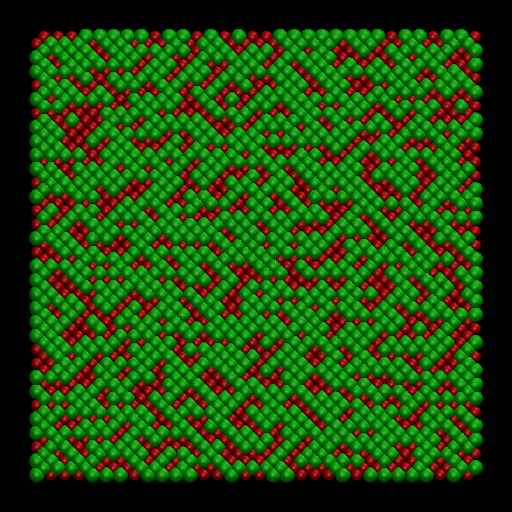

In [33]:
print('Re55')
Image("../reports/r55.png", width=300, height=300)

Re78


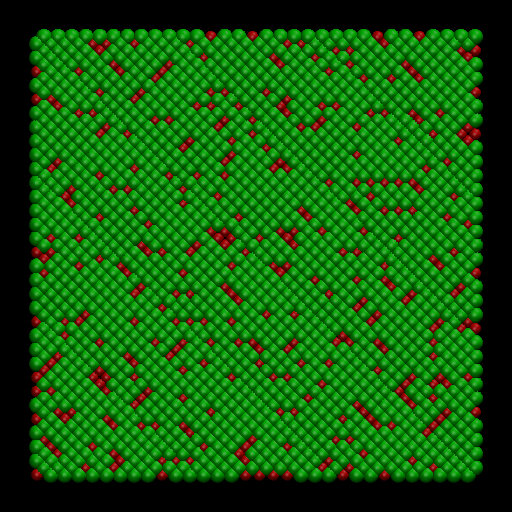

In [34]:
print('Re78')
Image("../reports/r78.png", width=300, height=300)

Re95


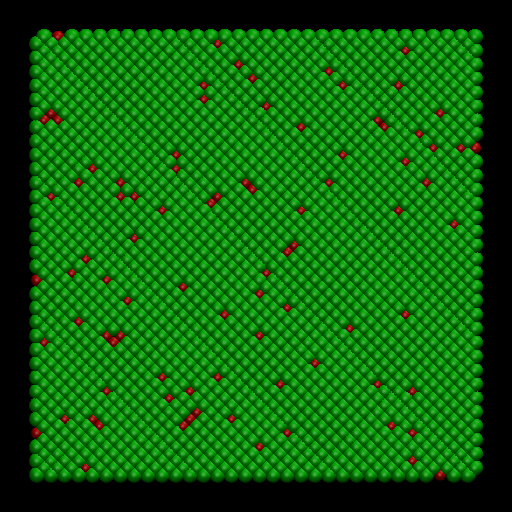

In [35]:
print('Re95')
Image("../reports/r95.png", width=300, height=300)

In [33]:
pwd

'/Users/l2v/work/images/mos2/notebooks'

**Notes**

* Design of experiments
* Estimate uncertainty
* Ensemble of models
* Simple physical models
* Statistical physics combined with machine learning.
* Physical models allow us to evaluate factor interactions. (alias matrix)